In [1]:
import re
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from get_log_class import GetLog

font = {'family' : 'normal', 'weight' : 'normal', 'size'   : 40} # weight can be "bold" or "normal"
plt.rc('font', **font)
plt.rcParams['pdf.fonttype'] = 42


inputDir = "/Users/Dinesh/Dropbox/Github/predicting_gex_with_nn_v2/Output/BC_genes/Output_BCgenes"
performance_metric = "test_loss" # "train_and_test_cbyr" # "test_cbyr" # "train_and_test_cbyr" # "test_cbyr"
use="median"  # "max", "min"

In [2]:
'''Get the cell lines that have < 21 files when the original set of dhs sites and TFs are used. This is 
21 b/c 4 of the files generated are layer sizes, and weight matrices.'''
samples_to_use = []  # has all 21 files
samples_not_used = []  # not any TF present so no TF / joint model present
orig_logs = {}  # {gene:[orig_log1, orig_log2, .. , orig_log5]}, where orig_log is log w/ orig DHSs and TFs.

for adir in os.listdir(inputDir):
    if (adir.__contains__("_T") and (adir.__contains__("_t"))
       and (not adir.__contains__("rTFs_rDHSs"))):
        agene = re.split("_", adir)[0]
        if (len(os.listdir(os.path.join(inputDir,adir))) == 21):  # note 21 b/c checked; could be different if script is changed
            samples_to_use.append(agene)
            alog = GetLog(os.path.join(inputDir, adir, agene+".log"))
            if (alog.isTainted):
                continue
            if (agene in orig_logs.keys()):
                orig_logs[agene].append(alog)
            else:
                orig_logs[agene] = [alog]
        else:
            samples_not_used.append(agene)

samples_to_use = set(samples_to_use)
samples_not_used = set(samples_not_used)

print(len(samples_to_use), len(samples_not_used))  # returns 224, 43

(224, 43)


In [3]:
'''Now get the random logs for the samples to use'''
random_logs = {}   # {gene:[random_log1, random_log2, .. , random_log5]}
for adir in os.listdir(inputDir):
    if (adir.__contains__("_T") and (adir.__contains__("_t"))
       and (adir.__contains__("rTFs_rDHSs"))):
        agene = re.split("_", adir)[0]
        if (agene in samples_to_use):
            alog = GetLog(os.path.join(inputDir, adir, agene+".log"))
            if (alog.isTainted):
                continue
            if (agene in random_logs.keys()):
                random_logs[agene].append(alog)
            else:
                random_logs[agene] = [alog]

In [4]:
# sns.boxplot(x="mode", y="perf", data=df_ns_pooled, fliersize=3)
def get_df_pooled_perf(dict_logs, use_best):
    pooled_perf = {}
    pooled_perf["mode"] = []
    pooled_perf["perf"] = []
    for agene in dict_logs.keys():  # dict_logs == {agene:[log1, log2, .., log5]}
        for amode in ["dhss", "tfs", "dhss_tfs"]:
            perfs = []
            for i, alog in enumerate(dict_logs[agene]):
                perfs.append(alog.get_best_perf(mode=amode, by=performance_metric))
            if (use_best):
                pooled_perf["mode"].append(amode)
                pooled_perf["perf"].append(np.median(perfs))  # this function defines "best"
            else:
                for aperf in perfs:
                    pooled_perf["mode"].append(amode)
                    pooled_perf["perf"].append(aperf)
    df_pooled_perf = pd.DataFrame(pooled_perf, columns=pooled_perf.keys())
    return df_pooled_perf

In [5]:
'''Plot boxplot from the pooled df'''
df_pooled_perf_orig = get_df_pooled_perf(orig_logs, use_best=True)  # see function to see what "best" means
df_pooled_perf_random = get_df_pooled_perf(random_logs, use_best=True)
df_pooled_perf_orig["orig_or_random"] = "orig"
df_pooled_perf_random["orig_or_random"] = "random"
df_pooled_perf_orig_and_random = pd.concat([df_pooled_perf_random, df_pooled_perf_orig])

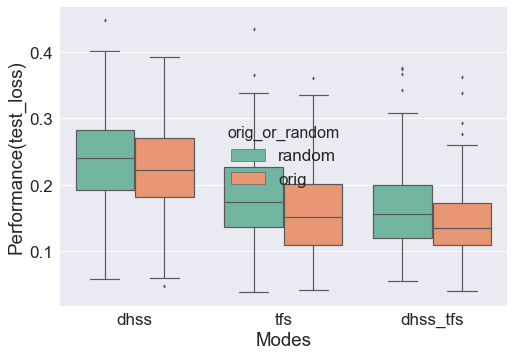

In [6]:
sns.set(font_scale=1.7)
sns.boxplot(x="mode", y="perf", data=df_pooled_perf_orig_and_random, 
            fliersize=3, hue="orig_or_random", palette="Set2", linewidth=1.2)
plt.ylabel("Performance({})".format(performance_metric))
plt.xlabel("Modes")
# plt.ylim(0,0.35)
plt.savefig("perf_many_bc_genes_{}.pdf".format(performance_metric))